In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
import xgboost as xgb

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

/Users/lelisra/Documents/vf/projects/tensorflow-vf/env/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Read data

In [2]:
df = pd.read_csv('./datasets/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

# Exploratory Data Analysis - EDA

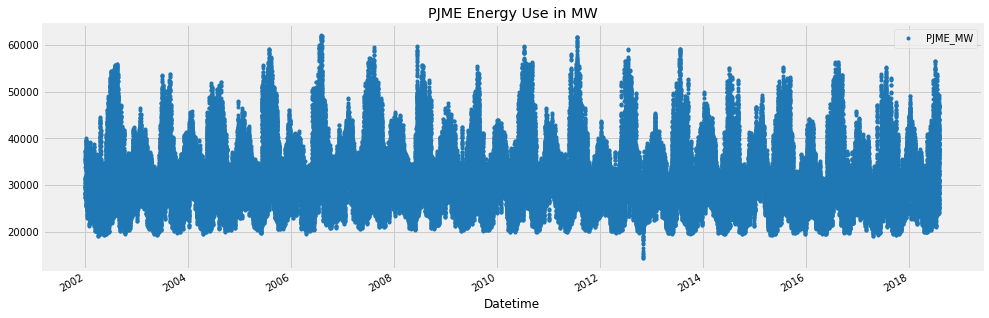

In [3]:
df.plot(
    style='.', 
    figsize=(15, 5), 
    color=color_pal[0], 
    title='PJME Energy Use in MW'
)
plt.show()

## Train / Test Split

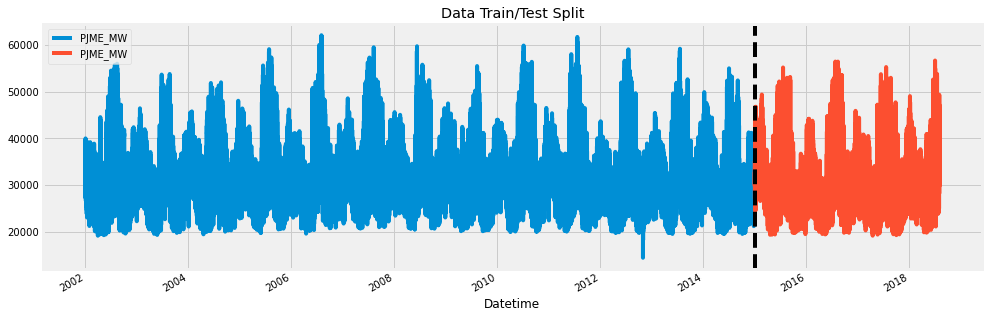

In [4]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))

train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
plt.show()

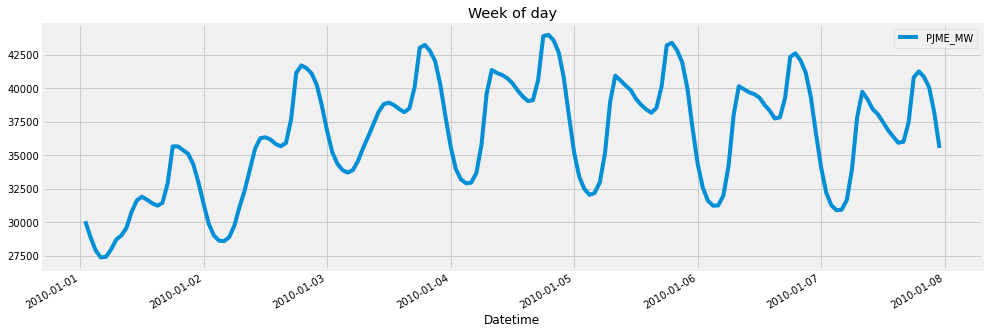

In [5]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15, 5), title='Week of day')
plt.show()

## Feature Creation

In [6]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [7]:
df = create_features(df)

## Visualize our Feature / Target Relationships

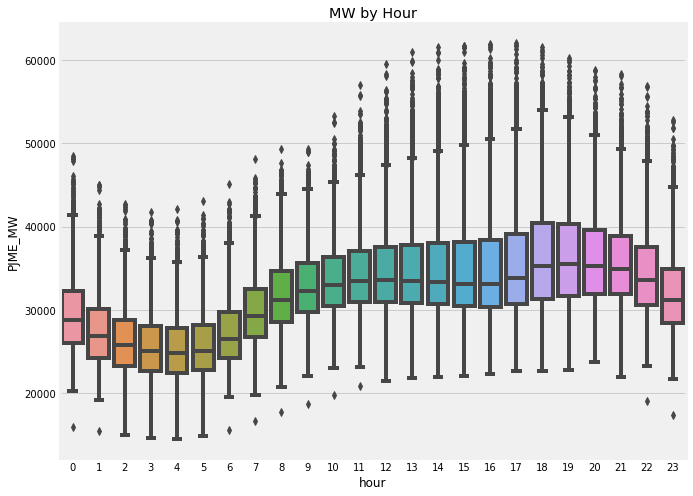

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

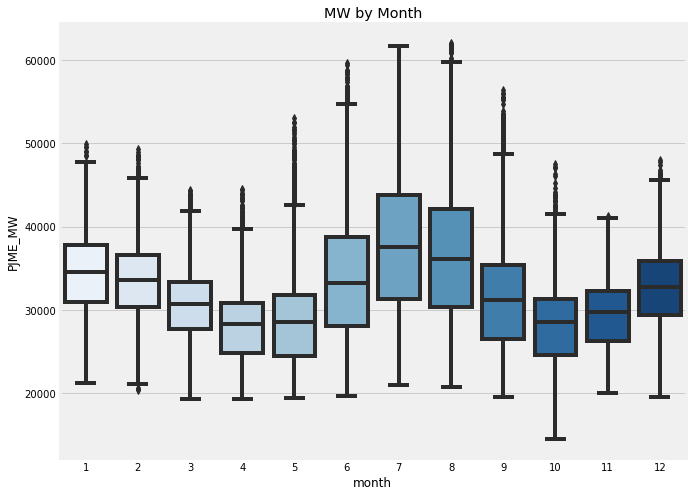

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

# Create our Model

In [10]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [11]:
reg = xgb.XGBRegressor(n_estimators=1000,
                       early_stopping_rounds=50,
                       learning_rate=0.01
                       )
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[18:48:34] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:32601.87695	validation_1-rmse:31654.28516


/Users/lelisra/Documents/vf/projects/tensorflow-vf/env/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:12342.13769	validation_1-rmse:11517.66016
[200]	validation_0-rmse:5373.33252	validation_1-rmse:5165.30762
[300]	validation_0-rmse:3375.20679	validation_1-rmse:3829.29810
[400]	validation_0-rmse:2882.54981	validation_1-rmse:3715.27002
[500]	validation_0-rmse:2699.48682	validation_1-rmse:3756.51269
[600]	validation_0-rmse:2601.12231	validation_1-rmse:3806.29639
[700]	validation_0-rmse:2516.63843	validation_1-rmse:3845.61450
[800]	validation_0-rmse:2459.07422	validation_1-rmse:3873.98120
[900]	validation_0-rmse:2423.80566	validation_1-rmse:3897.27808
[999]	validation_0-rmse:2377.90601	validation_1-rmse:3935.06543


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=10,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

## Feature Importances

In [12]:
# fi = pd.DataFrame(data=reg.feature_importances_,
#              index=reg.feature_names_in_,
#              columns=['importance'])
# fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
# plt.show()

# Forecast on Test

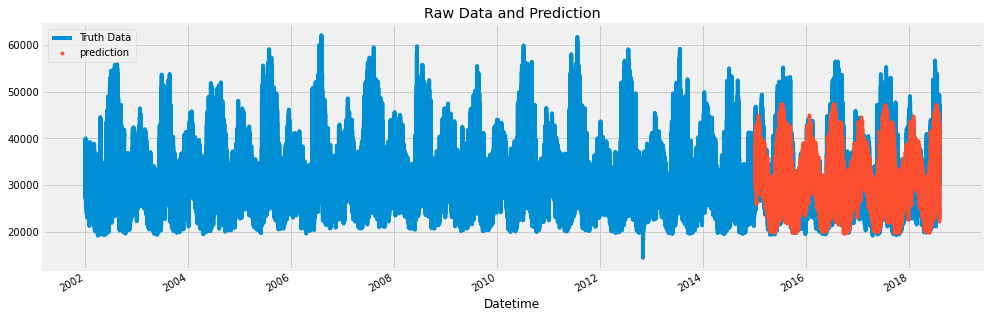

In [13]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'prediction'])
ax.set_title('Raw Data and Prediction')
plt.show()

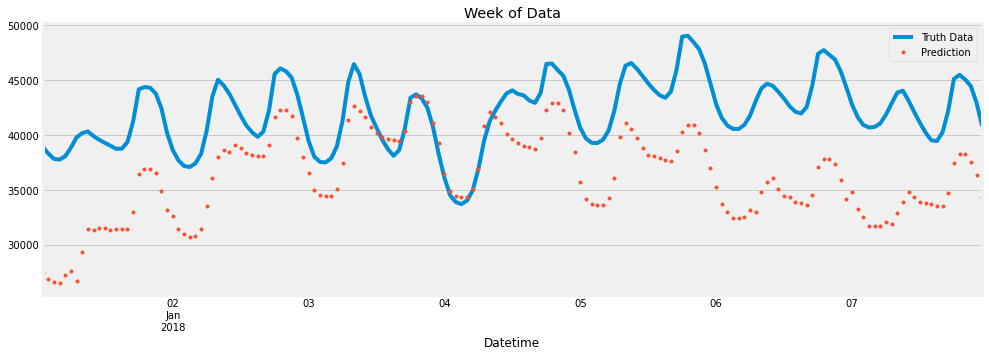

In [14]:
ax = df.loc[(df.index > '01-01-2018') & (df.index < '01-08-2018')]['PJME_MW']\
    .plot(figsize=(15, 5), title='Week of Data')
df.loc[(df.index > '01-01-2018') & (df.index < '01-08-2018')]['prediction']\
    .plot(style='.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

## How to optimize our model?
- By doing better parameter tunning 
- Add new feature to store specific days of the year such as holidays


# Evaluation metric

In [15]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3935.07


#### To improove this model, the lower the RMSE the better.

# Calculate the Error
- look at the worst and best predicted days

In [16]:
test['error'] = np.abs(test[TARGET] - test['prediction'])

In [17]:
test['date'] = test.index.date

In [18]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head(10)

date
2016-10-02    279.221436
2015-10-28    301.900228
2017-08-11    302.195882
2016-10-08    375.448161
2017-04-01    382.428385
2018-05-19    406.145915
2018-05-06    410.778971
2015-10-03    411.267008
2016-05-06    415.485107
2015-10-25    419.023193
Name: error, dtype: float64

# Next Steps
- More robust cross validation
- Add more features (weather forecast, holidays)